Bilayer unit domain. Sigma optimisation

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [2]:
# Define element size for the mesh refinement
h_i = [0.125/4,   # N=2
       0.125/8,   # N=3
       0.125/16,] # N=4
    # 0.0625 / 4,
    # 0.0625 / 8] 

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4
# sigma_0 = 1 #0.484375

# Solver configuration
requested_eigenvalues_number = 100 # Number of eigenvalues to compute

Solver configuration and computing

In [3]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-35.5j)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [4]:
def get_closest_eigenpair(solver, omega_target, verbose=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    """

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vr, vi = solver.getOperators()[0].getVecs()

    best = None

    for k in range(nconv):
        lam = solver.getEigenpair(k, vr) * 1j   # igual que tú haces

        dist = abs(lam - omega_target)          # distancia COMPLEJA correcta

        if best is None or dist < best[2]:
            best = (lam, k, dist)

    lam_best, idx_best, dist_best = best

    # Obtener el autovector correspondiente
    solver.getEigenpair(idx_best, vr)  # vr = autovector del modo idx_best
    x_best = vr.copy()                 # hacemos copia

    if verbose:
        print(f"[Closest] idx={idx_best}  λ={lam_best}  dist={dist_best}")

    return lam_best, idx_best


In [5]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

In [6]:
def get_exact_eigenpair(solver, selected_index, Q, V, x_hat, sigma_x, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))

    # sigma_x = lambda x: np.where(x[0] >= l_inner, sigma_0, 0)
    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x(x)))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

In [7]:
degree=[3,2]  # Polynomial degree for pressure and velocity

In [8]:
sigma_sweep_singular=np.linspace(0.25, 1.65, 11)

In [9]:
exact_omega = [None] * 5 
for j in np.arange(1, 6, 1):
    exact_omega[j-1] = get_exact_eigenvalue(j)

In [10]:
exact_omega

[np.complex128(12.566370614359172-2.197224577336219j),
 np.complex128(25.132741228718345-2.197224577336219j),
 np.complex128(37.69911184307752-2.197224577336219j),
 np.complex128(50.26548245743669-2.197224577336219j),
 np.complex128(62.83185307179586-2.197224577336219j)]

In [11]:
def group_by_real_part(eigenvalues, tolerance=1):
    groups = []
    for row in eigenvalues:
        for eig in row:
            added = False
            for group in groups:
                if abs(group[0].real - eig.real) < tolerance:
                    group.append(eig)
                    added = True
                    break
            if not added:
                groups.append([eig])
    return groups

In [12]:
# Initialize lists to store the approximated eigenpairs
approx_singular = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_singular))]

for i,sigma_0_singular in zip(range(len(sigma_sweep_singular)),sigma_sweep_singular):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[0]), [0, Lx + pml_thickness])

    # Define quadratic sigma function
    sigma_x_singular=lambda x: conditional(x[0] > Lx, sigma_0_singular/(Lx+pml_thickness-x[0]), 0.0)

    # Define solver for quadratic PML
    [solver_singular, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_singular)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_singular[i][j] = get_closest_eigenpair(solver_singular, exact_omega[j])[0]

groups_singular = group_by_real_part(approx_singular)

In [13]:
rel_error_eig_0_singular_n_2=abs((groups_singular[0] - exact_omega[0])) / np.abs(exact_omega[0])
rel_error_eig_1_singular_n_2=abs((groups_singular[3] - exact_omega[3])) / np.abs(exact_omega[3])

In [14]:
# Initialize lists to store the approximated eigenpairs
approx_singular = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_singular))]

for i,sigma_0_singular in zip(range(len(sigma_sweep_singular)),sigma_sweep_singular):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[1]), [0, Lx + pml_thickness])

    # Define singular sigma function
    sigma_x_singular=lambda x: conditional(x[0] > Lx, sigma_0_singular/(Lx+pml_thickness-x[0]), 0.0)

    # Define solver for singular PML
    [solver_singular, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_singular)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_singular[i][j] = get_closest_eigenpair(solver_singular, exact_omega[j])[0]

groups_singular = group_by_real_part(approx_singular)

In [15]:
rel_error_eig_0_singular_n_3=abs((groups_singular[0] - exact_omega[0])) / np.abs(exact_omega[0]) 
rel_error_eig_1_singular_n_3=abs((groups_singular[3] - exact_omega[3])) / np.abs(exact_omega[3]) 

In [16]:
# Initialize lists to store the approximated eigenpairs
approx_singular = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_singular))]

for i,sigma_0_singular in zip(range(len(sigma_sweep_singular)),sigma_sweep_singular):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[2]), [0, Lx + pml_thickness])

    # Define quadratic sigma function
    sigma_x_singular=lambda x: conditional(x[0] > Lx, sigma_0_singular/(Lx+pml_thickness-x[0]), 0.0)

    # Define solver for quadratic PML
    [solver_singular, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_singular)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_singular[i][j] = get_closest_eigenpair(solver_singular, exact_omega[j])[0]

groups_singular = group_by_real_part(approx_singular)

In [17]:
rel_error_eig_0_singular_n_4=abs((groups_singular[0] - exact_omega[0])) / np.abs(exact_omega[0]) 
rel_error_eig_1_singular_n_4=abs((groups_singular[3] - exact_omega[3])) / np.abs(exact_omega[3]) 

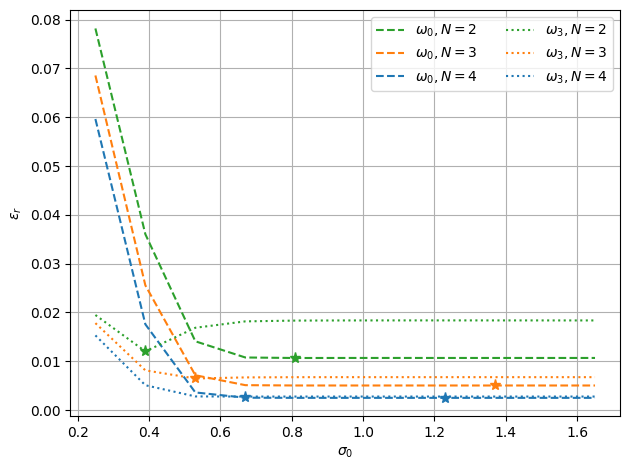

In [18]:
import matplotlib.pyplot as plt

# Definir colores manualmente (puedes elegir otros o usar un colormap como plt.cm.tab10)
colors = ['tab:green', 'tab:orange', 'tab:blue']  # uno por eig

# N=2, eig 0
plt.plot(sigma_sweep_singular, rel_error_eig_0_singular_n_2, color=colors[0], linestyle='--', label='$\omega_0, N=2$')
plt.plot(
    sigma_sweep_singular[np.argmin(rel_error_eig_0_singular_n_2)],
    rel_error_eig_0_singular_n_2[np.argmin(rel_error_eig_0_singular_n_2)],
    '*',
    color=colors[0],
    markersize=8,
)

# N=3, eig 0
plt.plot(sigma_sweep_singular, rel_error_eig_0_singular_n_3, color=colors[1], linestyle='--', label='$\omega_0, N=3$')
plt.plot(
    sigma_sweep_singular[np.argmin(rel_error_eig_0_singular_n_3)],
    rel_error_eig_0_singular_n_3[np.argmin(rel_error_eig_0_singular_n_3)],
    '*',
    color=colors[1],
    markersize=8,
)
# N=4, eig 0
plt.plot(sigma_sweep_singular, rel_error_eig_0_singular_n_4, color=colors[2], linestyle='--', label='$\omega_0, N=4$')
plt.plot(
    sigma_sweep_singular[np.argmin(rel_error_eig_0_singular_n_4)],
    rel_error_eig_0_singular_n_4[np.argmin(rel_error_eig_0_singular_n_4)],
    '*',
    color=colors[2],
    markersize=8,
)


# N=2, eig 1
plt.plot(sigma_sweep_singular, rel_error_eig_1_singular_n_2, color=colors[0], linestyle=':', label='$\omega_3, N=2$')
plt.plot(
    sigma_sweep_singular[np.argmin(rel_error_eig_1_singular_n_2)],
    rel_error_eig_1_singular_n_2[np.argmin(rel_error_eig_1_singular_n_2)],
    '*',
    color=colors[0],
    markersize=8,
)

# N=3, eig 1
plt.plot(sigma_sweep_singular, rel_error_eig_1_singular_n_3, color=colors[1], linestyle=':', label='$\omega_3, N=3$')
plt.plot(
    sigma_sweep_singular[np.argmin(rel_error_eig_1_singular_n_3)],
    rel_error_eig_1_singular_n_3[np.argmin(rel_error_eig_1_singular_n_3)],
    '*',
    color=colors[1],
    markersize=8,
)

# N=4, eig 1
plt.plot(sigma_sweep_singular, rel_error_eig_1_singular_n_4, color=colors[2], linestyle=':', label='$\omega_3, N=4 $')
plt.plot(
    sigma_sweep_singular[np.argmin(rel_error_eig_1_singular_n_4)],
    rel_error_eig_1_singular_n_4[np.argmin(rel_error_eig_1_singular_n_4)],
    '*',
    color=colors[2],
    markersize=8,
)

plt.xlabel('$\sigma_0$')
plt.ylabel(r'$\epsilon_r$')
plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [19]:
print(sigma_sweep_singular[np.argmin(rel_error_eig_0_singular_n_2)])
print(sigma_sweep_singular[np.argmin(rel_error_eig_0_singular_n_3)])
print(sigma_sweep_singular[np.argmin(rel_error_eig_0_singular_n_4)])

print(sigma_sweep_singular[np.argmin(rel_error_eig_1_singular_n_2)])
print(sigma_sweep_singular[np.argmin(rel_error_eig_1_singular_n_3)])
print(sigma_sweep_singular[np.argmin(rel_error_eig_1_singular_n_4)])

0.8099999999999999
1.3699999999999999
1.23
0.39
0.53
0.6699999999999999
